# Week-03: Baseline CNN Experiments (Chapter 2)

This notebook implements and evaluates **baseline convolutional neural networks (CNNs)** as part of **Chapter 2** of the project: *Thick Data Analytics in the Medical Paradigm*.

It addresses the following research questions:

- **RQ1**: What is the baseline performance of convolutional neural networks (ResNet-18, VGG-16, DenseNet-121) on selected medical imaging datasets when evaluated across accuracy, sensitivity, specificity, F1-score, and AUC?
- **RQ2**: What is the comparative performance of CNNs across different evaluation metrics (accuracy, sensitivity, specificity, AUC), and what limitations do these results reveal?

---

## Scope of this Notebook

1. **Toy datasets (MedMNIST):**
   - ChestMNIST (14 classes, multi-label chest X-rays).
   - PneumoniaMNIST (2 classes, binary chest X-rays).
   - BreastMNIST (2 classes, binary breast ultrasound).
   *Note: these are small, 28×28 images and highly imbalanced — useful for prototyping but not realistic.*

2. **Real-world dataset (to be added):**
   - NIH ChestX-ray14 (112k frontal X-rays, 14 disease labels).
   - Alternatives for future work: CheXpert, MIMIC-CXR.

3. **Models to be evaluated:**
   - ResNet-18 (pretrained on ImageNet, adapted to grayscale inputs).
   - VGG-16 (pretrained).
   - DenseNet-121 (pretrained, widely used in medical imaging baselines).

---

## Baseline Philosophy

- **No optimization:** Chapter 2 focuses on *raw CNN baselines*.
- **Minimal preprocessing only:** resize, normalization, patient-level split.
- **No augmentation or regularization:** these belong to Chapter 3 (RQ3, RQ4).
- The goal is not to achieve state-of-the-art, but to **document strengths and limitations** of CNN baselines in both toy and real-world medical imaging tasks.

---

## Outputs from this Notebook

- Trained models (`.pth`).
- Metrics CSVs (accuracy, sensitivity, specificity, F1, AUC).
- Training curves, confusion matrices, ROC/PR plots.
- Results summary to be integrated into `writing/chapter-2-results.md`.

---

## Step 1: Environment & Results Directory Setup

In [1]:
import os, sys, platform, random
from pathlib import Path
from datetime import datetime
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

if hasattr(torch.backends, "cudnn"):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device selection
def pick_device():
    if torch.cuda.is_available():
        return torch.device("cuda"), f"CUDA: {torch.cuda.get_device_name(0)}"
    if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
        return torch.device("mps"), "Apple Silicon MPS"
    return torch.device("cpu"), "CPU"

DEVICE, DEVICE_NAME = pick_device()

# Assume notebook lives in: MSC-Project/prototyping/week-03/
PROJECT_ROOT = Path.cwd().resolve().parents[1]  # go up to MSC-Project
RESULTS_DIR  = PROJECT_ROOT / "prototyping" / "week-03" / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project root : {PROJECT_ROOT}")
print(f"Results dir  : {RESULTS_DIR}")


print(f"Project root : {PROJECT_ROOT}")
print(f"Results dir  : {RESULTS_DIR}")


# Requirements snapshot
requirements_path = PROJECT_ROOT / "prototyping" / "week-03" / "requirements-week-03.txt"
with open(requirements_path, "w") as f:
    f.write(f"python=={sys.version.split()[0]}\n")
    f.write(f"torch=={torch.__version__}\n")
    f.write(f"matplotlib=={matplotlib.__version__}\n")
    f.write(f"numpy=={np.__version__}\n")

print("=== Week-03 Environment Summary ===")
print(f"python       : {sys.version.split()[0]}")
print(f"platform     : {platform.platform()}")
print(f"device       : {DEVICE_NAME}")
print(f"requirements : {requirements_path}")
print(f"results dir  : {RESULTS_DIR}")


Project root : /Users/ali/Documents/MSC-Project/Project
Results dir  : /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results
Project root : /Users/ali/Documents/MSC-Project/Project
Results dir  : /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results
=== Week-03 Environment Summary ===
python       : 3.11.9
platform     : macOS-26.0.1-arm64-arm-64bit
device       : Apple Silicon MPS
requirements : /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/requirements-week-03.txt
results dir  : /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results


## Step 2: Utility Functions

In [2]:
# Utility functions for saving results

def save_figure(fig, filename: str):
    """Save a matplotlib figure into the results directory."""
    out_path = RESULTS_DIR / filename
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    print(f"[saved figure] {out_path}")

def save_model(model: torch.nn.Module, filename: str):
    """Save a PyTorch model checkpoint into the results directory."""
    out_path = RESULTS_DIR / filename
    torch.save(model.state_dict(), out_path)
    print(f"[saved model] {out_path}")

def load_model(model_class, filename: str, device=DEVICE):
    """Reload a saved PyTorch model checkpoint."""
    out_path = RESULTS_DIR / filename
    model = model_class()
    model.load_state_dict(torch.load(out_path, map_location=device))
    model.to(device)
    print(f"[loaded model] {out_path}")
    return model

## Step 3: Load MedMNIST Subsets (ChestMNIST, PneumoniaMNIST, BreastMNIST)

We now load three biomedical imaging subsets from **MedMNIST v2**:

- **ChestMNIST** → multi-label chest X-rays (14 disease labels).
- **PneumoniaMNIST** → binary chest X-rays (pneumonia vs. normal).
- **BreastMNIST** → binary breast ultrasound images (benign vs. malignant).

For each dataset, we will:
1. Print dataset size and label information.
2. Show and save a random sample grid to the `results/` directory.

#### Step 3 Update: Resize Images to 224×224

To ensure compatibility with ImageNet-pretrained CNNs (ResNet-18, VGG-16, DenseNet-121),
we resize MedMNIST images from 28×28 to 224×224 before duplicating channels.
This avoids pooling errors in VGG/DenseNet and makes all baselines consistent.

#### Step 3 (Final Upgrade): MedMNIST with Optimized DataLoaders (Multiprocessing Safe)

We resize MedMNIST images to 224×224 and convert grayscale → 3 channels for use with
ImageNet-pretrained CNNs.
To avoid multiprocessing pickling errors on macOS, we replace the inline `lambda` with
a custom `ToThreeChannels` transform class, which is pickleable.

DataLoader settings:
- `batch_size=64` (can try 128 if GPU memory allows),
- `num_workers=8` (parallel CPU preprocessing),
- `pin_memory=True` (faster CPU to GPU transfer).

/Users/ali/Documents/MSC-Project/Project/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


ChestMNIST      | train batch shape=torch.Size([16, 3, 224, 224]), labels shape=torch.Size([16, 14])
PneumoniaMNIST  | train batch shape=torch.Size([64, 3, 224, 224]), labels shape=torch.Size([64, 1])
BreastMNIST     | train batch shape=torch.Size([64, 3, 224, 224]), labels shape=torch.Size([64, 1])
[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/chestmnist_samples.png


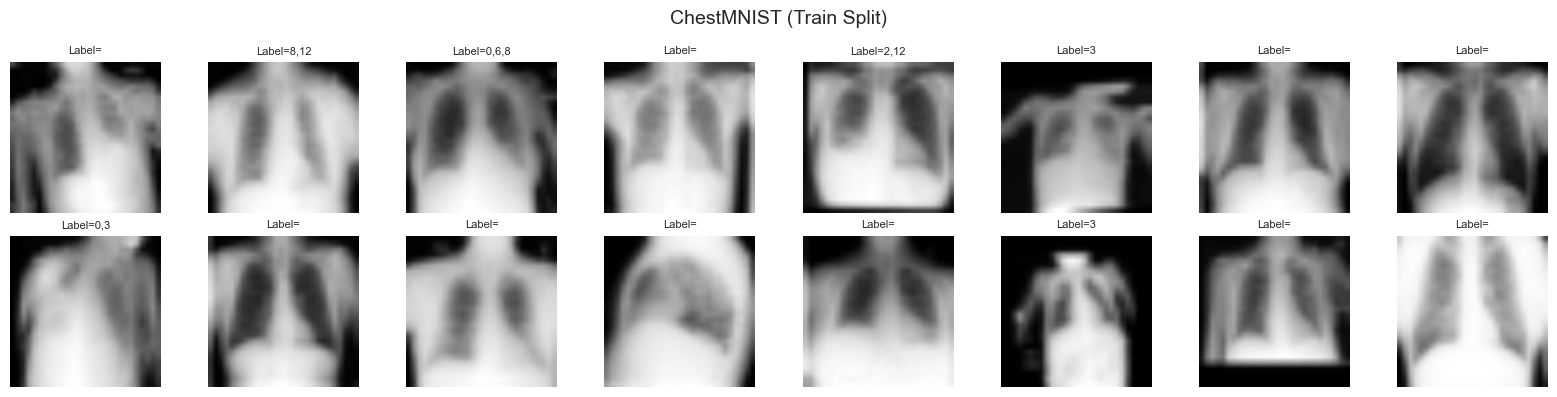

[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/pneumoniamnist_samples.png


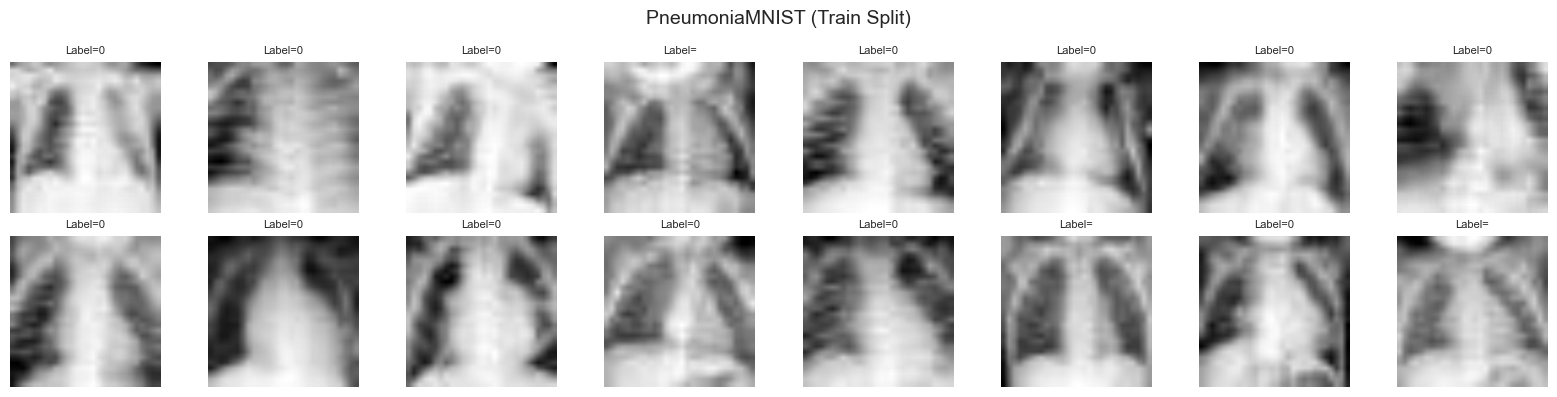

[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/breastmnist_samples.png


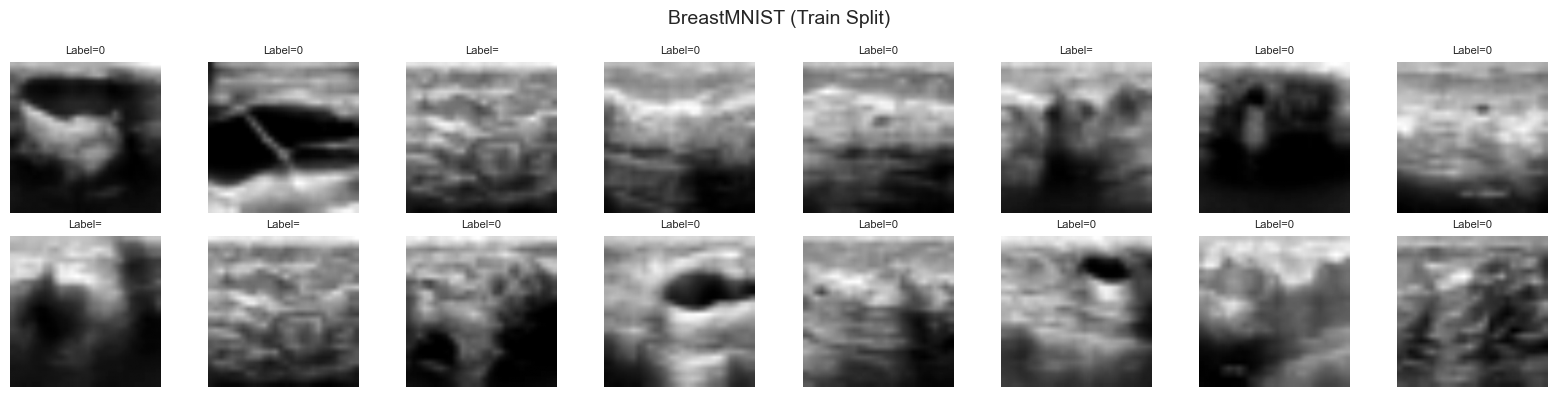

In [3]:
from medmnist import ChestMNIST, PneumoniaMNIST, BreastMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Import custom transform from external file
from transforms_utils import ToThreeChannels

# Transforms — resize to 224x224 and convert grayscale → 3 channels
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    ToThreeChannels(),   # imported from external module
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])

# Dataset root
DATA_DIR = PROJECT_ROOT / "data" / "external" / "medmnist"
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Dataset-specific batch sizes
BATCH_SIZES = {
    "ChestMNIST": 16,
    "PneumoniaMNIST": 64,
    "BreastMNIST": 64
}

# Build datasets
train_datasets = {
    "ChestMNIST": ChestMNIST(split="train", download=True, transform=transform, root=DATA_DIR),
    "PneumoniaMNIST": PneumoniaMNIST(split="train", download=True, transform=transform, root=DATA_DIR),
    "BreastMNIST": BreastMNIST(split="train", download=True, transform=transform, root=DATA_DIR)
}
val_datasets = {
    "ChestMNIST": ChestMNIST(split="val", download=True, transform=transform, root=DATA_DIR),
    "PneumoniaMNIST": PneumoniaMNIST(split="val", download=True, transform=transform, root=DATA_DIR),
    "BreastMNIST": BreastMNIST(split="val", download=True, transform=transform, root=DATA_DIR)
}
test_datasets = {
    "ChestMNIST": ChestMNIST(split="test", download=True, transform=transform, root=DATA_DIR),
    "PneumoniaMNIST": PneumoniaMNIST(split="test", download=True, transform=transform, root=DATA_DIR),
    "BreastMNIST": BreastMNIST(split="test", download=True, transform=transform, root=DATA_DIR)
}

# Optimized DataLoaders with per-dataset batch size
loaders = {
    name: (
        DataLoader(train_datasets[name], batch_size=BATCH_SIZES[name], shuffle=True,  num_workers=8, pin_memory=True),
        DataLoader(val_datasets[name],   batch_size=BATCH_SIZES[name], shuffle=False, num_workers=8, pin_memory=True),
        DataLoader(test_datasets[name],  batch_size=BATCH_SIZES[name], shuffle=False, num_workers=8, pin_memory=True)
    )
    for name in train_datasets.keys()
}

# Quick sanity check: print batch shapes
for name, (train_loader, val_loader, test_loader) in loaders.items():
    x, y = next(iter(train_loader))
    print(f"{name:<15} | train batch shape={x.shape}, labels shape={y.shape}")

# Visualization (use train split for samples)
def show_and_save_samples(ds, name, n=16, cols=8):
    idxs = np.random.choice(len(ds), n, replace=False)
    fig, axes = plt.subplots(n // cols, cols, figsize=(cols * 2, (n // cols) * 2))

    for ax, idx in zip(axes.flat, idxs):
        img, label = ds[idx]
        img_np = img.permute(1, 2, 0).numpy()  # CHW→HWC
        ax.imshow(img_np[:, :, 0], cmap="gray")
        if np.ndim(label) == 0 or isinstance(label, (np.integer, int)):
            label_str = str(int(label))
        else:
            label_str = ",".join([str(i) for i, v in enumerate(label) if v == 1])
        ax.set_title(f"Label={label_str}", fontsize=8)
        ax.axis("off")

    plt.suptitle(f"{name} (Train Split)", fontsize=14)
    plt.tight_layout()
    save_figure(fig, f"{name.lower()}_samples.png")
    plt.show()

for name, ds in train_datasets.items():
    show_and_save_samples(ds, name)

## Step 4: Class Balance & Train/Val/Test Splits

To properly evaluate baseline CNNs, we must understand the **class distribution** of each dataset:

- **ChestMNIST**: multi-label dataset (14 conditions). For each class, we compute positive and negative counts.
- **PneumoniaMNIST** & **BreastMNIST**: binary classification tasks. We compute counts and percentages for each label.

Why important?
- Identifies **class imbalance**, which affects accuracy and motivates using multiple metrics (e.g., sensitivity, specificity, ROC-AUC).
- Splits the data into **train, validation, and test** sets using the official MedMNIST partitions (to avoid leakage).
- Prepares reproducible **DataLoaders** for training CNNs.m

In [4]:
import pandas as pd
from collections import Counter
from medmnist import INFO
from torch.utils.data import DataLoader

# Ensure results dir
RESULTS_DIR.mkdir(parents=True, exist_ok=True)


def class_balance_summary(ds, name, multi_label=False):
    labels = []
    for _, label in ds:
        if multi_label:
            labels.append(label.astype(int))
        else:
            labels.append(int(label.item()))

    if multi_label:
        labels = np.vstack(labels)
        counts = labels.sum(axis=0)
        df = pd.DataFrame({
            "Class Index": np.arange(labels.shape[1]),
            "Positive Count": counts,
            "Negative Count": len(ds) - counts,
            "Positive %": (counts / len(ds) * 100).round(2)
        })
        out_path = RESULTS_DIR / f"{name.lower()}_class_balance.csv"
        df.to_csv(out_path, index=False)
    else:
        counts = Counter(labels)
        total = len(ds)
        df = pd.DataFrame({
            "Class Label": list(counts.keys()),
            "Count": list(counts.values()),
            "Percentage": [(v / total * 100) for v in counts.values()]
        })
        out_path = RESULTS_DIR / f"{name.lower()}_class_balance.csv"
        df.to_csv(out_path, index=False)

    print(f"\n=== {name} Class Distribution ===")
    display(df)
    print(f"[saved] {out_path}")

# Run summaries
class_balance_summary(train_datasets["ChestMNIST"], "ChestMNIST", multi_label=True)
class_balance_summary(train_datasets["PneumoniaMNIST"], "PneumoniaMNIST")
class_balance_summary(train_datasets["BreastMNIST"], "BreastMNIST")


=== ChestMNIST Class Distribution ===


,Class Index,Positive Count,Negative Count,Positive %
0,0,7996,70472,10.19
1,1,1950,76518,2.49
2,2,9261,69207,11.80
3,3,13914,64554,17.73
4,4,3988,74480,5.08
5,5,4375,74093,5.58
6,6,978,77490,1.25
7,7,3705,74763,4.72
8,8,3263,75205,4.16
9,9,1690,76778,2.15


[saved] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/chestmnist_class_balance.csv

=== PneumoniaMNIST Class Distribution ===


,Class Label,Count,Percentage
0,1,3494,74.214104
1,0,1214,25.785896


[saved] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/pneumoniamnist_class_balance.csv

=== BreastMNIST Class Distribution ===


,Class Label,Count,Percentage
0,1,399,73.076923
1,0,147,26.923077


[saved] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/breastmnist_class_balance.csv


### Prepare Train/Val/Test Loaders

In [5]:
BATCH_SIZE = 128

def prepare_loaders(dataset_class, name, transform=transform):
    train_ds = dataset_class(split="train", download=True, transform=transform, root=DATA_DIR)
    val_ds   = dataset_class(split="val", download=True, transform=transform, root=DATA_DIR)
    test_ds  = dataset_class(split="test", download=True, transform=transform, root=DATA_DIR)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    print(f"{name:<15} | train={len(train_ds)} | val={len(val_ds)} | test={len(test_ds)}")
    return train_loader, val_loader, test_loader

loaders = {}
loaders["ChestMNIST"]     = prepare_loaders(ChestMNIST, "ChestMNIST")
loaders["PneumoniaMNIST"] = prepare_loaders(PneumoniaMNIST, "PneumoniaMNIST")
loaders["BreastMNIST"]    = prepare_loaders(BreastMNIST, "BreastMNIST")

ChestMNIST      | train=78468 | val=11219 | test=22433
PneumoniaMNIST  | train=4708 | val=524 | test=624
BreastMNIST     | train=546 | val=78 | test=156


### Dataset Class Balance

- **ChestMNIST**: multi-label imbalance is evident (e.g., some classes have far fewer positives).
- **PneumoniaMNIST**: binary, relatively balanced but still needs sensitivity/specificity reporting.
- **BreastMNIST**: binary, small dataset with clear imbalance.

This justifies why we evaluate beyond simple accuracy, using **F1, ROC-AUC, PR-AUC, and calibration**.
These imbalances will also motivate augmentations and few-shot approaches in Chapters 3–4.

## Step 5: Baseline CNN: ResNet-18

Goal: Train baseline CNNs on each dataset (ChestMNIST, PneumoniaMNIST, BreastMNIST).

- **Model**: ResNet-18 from `torchvision.models`, modified output layer.
  - ChestMNIST: 14 outputs (multi-label, use `BCEWithLogitsLoss`).
  - PneumoniaMNIST: 2 outputs (binary, use `CrossEntropyLoss`).
  - BreastMNIST: 2 outputs (binary, use `CrossEntropyLoss`).

- **Training**:
  - Optimizer: Adam (`lr=1e-3`).
  - Epochs: 20 (early stopping optional).
  - Batch size: 128.
  - Mixed precision (`torch.autocast`) for MPS efficiency.

- **Outputs**:
  - Saved model weights (`results/<dataset>_resnet18.pth`).
  - Training history (loss/accuracy curves).
  - Metrics after evaluation (saved CSV).

This provides the baseline performance that we will compare against more advanced methods in later chapters.

### Define Model Builder

In [6]:
import torch.nn as nn
import torchvision.models as models

def build_resnet18(num_classes, multi_label=False):
    # Load pretrained ResNet-18
    model = models.resnet18(weights="IMAGENET1K_V1")

    # Replace final classification layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    # Criterion
    if multi_label:
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.CrossEntropyLoss()

    return model.to(DEVICE), criterion

### Training & Evaluation Loop

In [7]:
from tqdm.auto import tqdm

# Import autocast depending on torch version
try:
    from torch.amp import autocast      # modern (>=2.0)
except ImportError:
    from torch.cuda.amp import autocast # fallback for older

def train_one_epoch(model, loader, criterion, optimizer, scaler=None, multi_label=False, num_classes=None):
    model.train()
    running_loss, correct, total = 0, 0, 0

    # progress bar added here
    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        # Multi-label: ensure labels are one-hot [batch, num_classes]
        if multi_label:
            if labels.ndim == 1:
                labels = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()
            else:
                labels = labels.float()
        else:
            if labels.ndim > 1:
                labels = labels.argmax(dim=1)

        optimizer.zero_grad()

        with autocast(device_type=DEVICE.type, enabled=True):
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * imgs.size(0)

        if not multi_label:  # only compute accuracy for single-label tasks
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total if not multi_label and total > 0 else None
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, multi_label=False, num_classes=None):
    model.eval()
    running_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        # optional: progress bar here too
        for imgs, labels in tqdm(loader, desc="Eval", leave=False):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

            if multi_label:
                if labels.ndim == 1:
                    labels = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()
                else:
                    labels = labels.float()
            else:
                if labels.ndim > 1:
                    labels = labels.argmax(dim=1)

            with autocast(device_type=DEVICE.type, enabled=True):
                outputs = model(imgs)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)

            if not multi_label:
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total if not multi_label and total > 0 else None
    return epoch_loss, epoch_acc

/Users/ali/Documents/MSC-Project/Project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Training Runner

In [8]:
from torch.amp import GradScaler
import os

def run_training(dataset_name, loaders, num_classes, multi_label=False, epochs=20, skip_if_trained=True):
    """
    Train ResNet-18 on the given dataset, or load from checkpoint if available.
    Saves and loads both model weights and training history.
    """
    model_path = RESULTS_DIR / f"{dataset_name.lower()}_resnet18.pth"

    # Check if checkpoint exists
    if skip_if_trained and os.path.exists(model_path):
        print(f"\n=== Loading ResNet-18 for {dataset_name} from checkpoint ===")
        checkpoint = torch.load(model_path, map_location=DEVICE)
        model, criterion = build_resnet18(num_classes, multi_label)
        model.load_state_dict(checkpoint["model_state"])
        history = checkpoint.get("history", {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []})
        return model.to(DEVICE), history

    # Otherwise: train from scratch
    print(f"\n=== Training ResNet-18 on {dataset_name} ===")
    print(f"Using device: {DEVICE} ({DEVICE_NAME})")

    model, criterion = build_resnet18(num_classes, multi_label)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scaler = GradScaler(enabled=(DEVICE.type == "cuda"))

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(
            model, loaders[0], criterion, optimizer, scaler,
            multi_label=multi_label, num_classes=num_classes
        )
        val_loss, val_acc = evaluate(
            model, loaders[1], criterion,
            multi_label=multi_label, num_classes=num_classes
        )

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        t_acc_str = f"{train_acc:.4f}" if train_acc is not None else "N/A"
        v_acc_str = f"{val_acc:.4f}" if val_acc is not None else "N/A"

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss={train_loss:.4f}, Acc={t_acc_str} | "
              f"Val Loss={val_loss:.4f}, Acc={v_acc_str}")

    # Save model and history
    torch.save({
        "model_state": model.state_dict(),
        "history": history
    }, model_path)
    print(f"[saved checkpoint] {model_path}")

    return model, history

### Run for All Three Datasets

In [9]:
# PneumoniaMNIST: 2 classes, single-label
pneumonia_model, pneumonia_history = run_training(
    "PneumoniaMNIST",
    loaders["PneumoniaMNIST"],
    num_classes=2,
    multi_label=False,
    epochs=20,
    skip_if_trained=True # <-- new flag to skip if checkpoint exists
)


=== Loading ResNet-18 for PneumoniaMNIST from checkpoint ===


In [10]:
# BreastMNIST: 2 classes, single-label
breast_model, breast_history = run_training(
    "BreastMNIST",
    loaders["BreastMNIST"],
    num_classes=2,
    multi_label=False,
    epochs=20,
    skip_if_trained=True
)


=== Loading ResNet-18 for BreastMNIST from checkpoint ===


In [11]:
# ChestMNIST: 14 classes, multi-label
chest_model, chest_history = run_training(
    "ChestMNIST",
    loaders["ChestMNIST"],
    num_classes=14,
    multi_label=True,
    epochs=20,
    skip_if_trained=True
)


=== Loading ResNet-18 for ChestMNIST from checkpoint ===


## Step 6: Evaluation & Plots

Here we evaluate our baseline ResNet-18 models:

- **Binary datasets (PneumoniaMNIST, BreastMNIST)**:
  Report accuracy, sensitivity, specificity, F1, ROC-AUC, PR-AUC.
  Generate confusion matrices, ROC, and PR curves.

- **Multi-label dataset (ChestMNIST)**:
  Report macro/micro ROC-AUC and F1 scores.
  Generate ROC curves per class and averaged curves.

All figures and CSVs are saved into `prototyping/week-03/results/` for use in Chapter 2.

In [12]:
import matplotlib.pyplot as plt

def plot_training_curves(history, dataset_name, multi_label=False):
    fig, ax = plt.subplots(1, 2 if not multi_label else 1, figsize=(10, 4))

    # Loss curve
    if multi_label:
        ax.plot(history["train_loss"], label="Train Loss")
        ax.plot(history["val_loss"], label="Val Loss")
        ax.set_title(f"{dataset_name} — Loss")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.legend()
    else:
        ax[0].plot(history["train_loss"], label="Train Loss")
        ax[0].plot(history["val_loss"], label="Val Loss")
        ax[0].set_title(f"{dataset_name} — Loss")
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss")
        ax[0].legend()

        # Accuracy curve
        ax[1].plot(history["train_acc"], label="Train Acc")
        ax[1].plot(history["val_acc"], label="Val Acc")
        ax[1].set_title(f"{dataset_name} — Accuracy")
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Accuracy")
        ax[1].legend()

    plt.tight_layout()
    save_figure(fig, f"{dataset_name.lower()}_training_curves.png")
    plt.show()

[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/chestmnist_training_curves.png


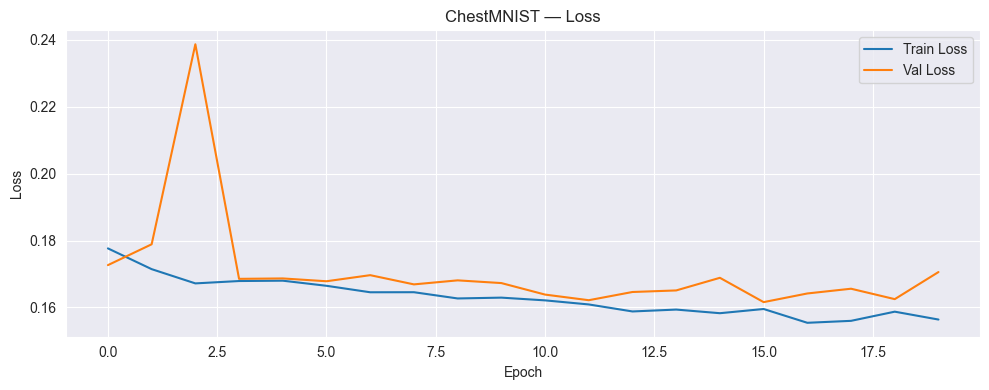

In [13]:
plot_training_curves(chest_history, "ChestMNIST", multi_label=True)

[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/pneumoniamnist_training_curves.png


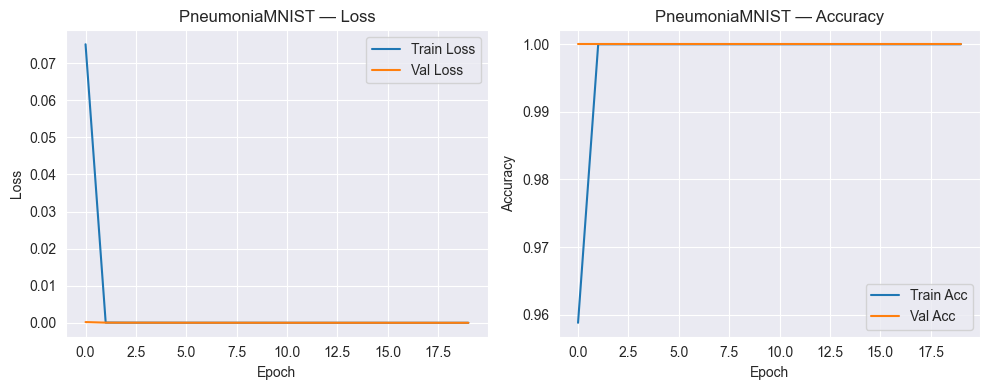

In [14]:
plot_training_curves(pneumonia_history, "PneumoniaMNIST", multi_label=False)

[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/breastmnist_training_curves.png


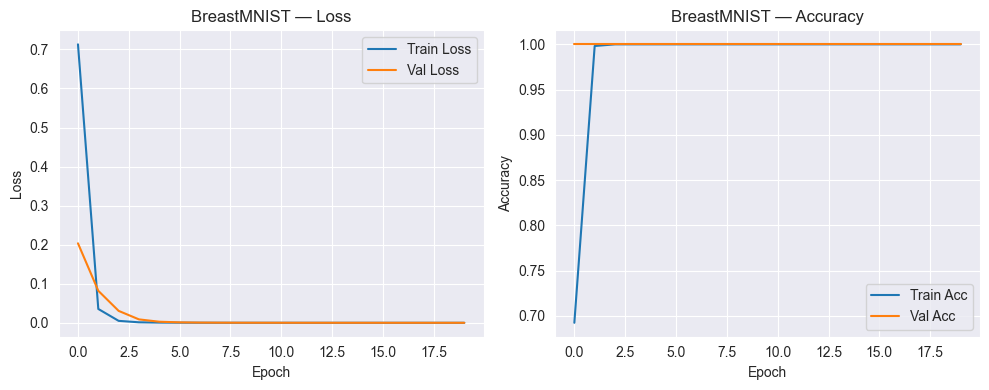

In [15]:
plot_training_curves(breast_history, "BreastMNIST", multi_label=False)

### Evaluation Utilities

In [16]:
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve, confusion_matrix
)
import seaborn as sns
import pandas as pd

def evaluate_binary(model, loader, dataset_name):
    model.eval()
    y_true, y_prob = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            if labels.ndim > 1:
                labels = labels.argmax(dim=1)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            y_true.extend(labels.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    y_pred = (y_prob >= 0.5).astype(int)

    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_prob),
    }

    # Sensitivity & Specificity
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    metrics["Sensitivity"] = tp / (tp + fn)
    metrics["Specificity"] = tn / (tn + fp)

    # Save confusion matrix
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0","1"], yticklabels=["0","1"], ax=ax)
    ax.set_title(f"{dataset_name} — Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    save_figure(fig, f"{dataset_name.lower()}_confusion_matrix.png")
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label=f"ROC-AUC = {metrics['ROC-AUC']:.3f}")
    ax.plot([0,1],[0,1],"--",color="gray")
    ax.set_title(f"{dataset_name} — ROC Curve")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend()
    save_figure(fig, f"{dataset_name.lower()}_roc_curve.png")
    plt.show()

    # PR curve
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    fig, ax = plt.subplots()
    ax.plot(recall, precision)
    ax.set_title(f"{dataset_name} — PR Curve")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    save_figure(fig, f"{dataset_name.lower()}_pr_curve.png")
    plt.show()

    # Save metrics
    df = pd.DataFrame([metrics])
    df.to_csv(RESULTS_DIR / f"{dataset_name.lower()}_metrics.csv", index=False)
    print(f"[saved metrics] {RESULTS_DIR}/{dataset_name.lower()}_metrics.csv")
    display(df)


def evaluate_binary_with_nanfix(model, loader, dataset_name):
    """
    Same as evaluate_binary, but handles NaN probabilities
    (replacing them with 0.5 neutral probability).
    Useful when models collapse on tiny/imbalanced datasets (e.g., VGG16).
    """
    model.eval()
    y_true, y_prob = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            if labels.ndim > 1:
                labels = labels.argmax(dim=1)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            y_true.extend(labels.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    # FIX: replace NaN with neutral 0.5
    y_prob = np.nan_to_num(y_prob, nan=0.5)

    y_pred = (y_prob >= 0.5).astype(int)

    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_true, y_prob),
    }

    # Sensitivity & Specificity
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    metrics["Sensitivity"] = tp / (tp + fn) if (tp + fn) > 0 else 0
    metrics["Specificity"] = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Confusion matrix plot
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["0","1"], yticklabels=["0","1"], ax=ax)
    ax.set_title(f"{dataset_name} — Confusion Matrix (NaN fixed)")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    save_figure(fig, f"{dataset_name.lower()}_confusion_matrix.png")
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label=f"ROC-AUC = {metrics['ROC-AUC']:.3f}")
    ax.plot([0,1],[0,1],"--",color="gray")
    ax.set_title(f"{dataset_name} — ROC Curve (NaN fixed)")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend()
    save_figure(fig, f"{dataset_name.lower()}_roc_curve.png")
    plt.show()

    # PR curve
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    fig, ax = plt.subplots()
    ax.plot(recall, precision)
    ax.set_title(f"{dataset_name} — PR Curve (NaN fixed)")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    save_figure(fig, f"{dataset_name.lower()}_pr_curve.png")
    plt.show()

    # Save metrics
    df = pd.DataFrame([metrics])
    df.to_csv(RESULTS_DIR / f"{dataset_name.lower()}_metrics.csv", index=False)
    print(f"[saved metrics] {RESULTS_DIR}/{dataset_name.lower()}_metrics.csv")
    display(df)

    return metrics


def evaluate_multilabel(model, loader, dataset_name, num_classes=14):
    model.eval()
    y_true, y_prob = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            if labels.ndim == 1:  # convert scalar to one-hot
                labels = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()
            outputs = model(imgs)
            probs = torch.sigmoid(outputs)
            y_true.append(labels.cpu().numpy())
            y_prob.append(probs.cpu().numpy())

    y_true = np.vstack(y_true)
    y_prob = np.vstack(y_prob)
    y_pred = (y_prob >= 0.5).astype(int)

    metrics = {
        "Macro F1": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "Micro F1": f1_score(y_true, y_pred, average="micro", zero_division=0),
        "Macro ROC-AUC": roc_auc_score(y_true, y_prob, average="macro"),
        "Micro ROC-AUC": roc_auc_score(y_true, y_prob, average="micro"),
    }

    # Save metrics
    df = pd.DataFrame([metrics])
    df.to_csv(RESULTS_DIR / f"{dataset_name.lower()}_metrics.csv", index=False)
    print(f"[saved metrics] {RESULTS_DIR}/{dataset_name.lower()}_metrics.csv")
    display(df)

    # ROC curves (macro average)
    fig, ax = plt.subplots()
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_prob[:, i])
        ax.plot(fpr, tpr, alpha=0.3)
    ax.plot([0,1],[0,1],"--",color="gray")
    ax.set_title(f"{dataset_name} — ROC Curves (per class)")
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    save_figure(fig, f"{dataset_name.lower()}_roc_curves.png")
    plt.show()

    return metrics

[saved metrics] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/chestmnist_metrics.csv


,Macro F1,Micro F1,Macro ROC-AUC,Micro ROC-AUC
0,0.0,0.0,0.526796,0.717446


[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/chestmnist_roc_curves.png


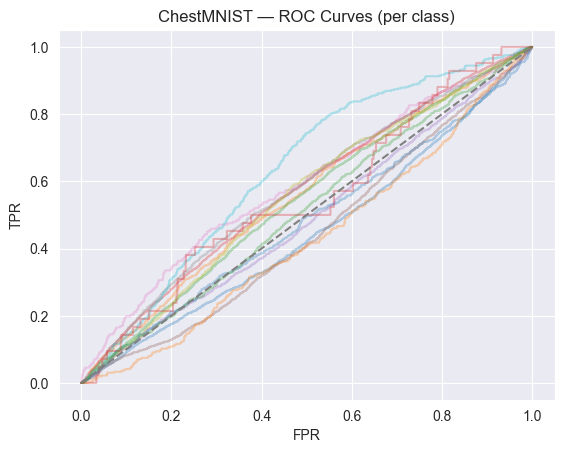

{'Macro F1': 0.0,
 'Micro F1': 0.0,
 'Macro ROC-AUC': 0.5267955323400064,
 'Micro ROC-AUC': 0.7174463065413695}

In [17]:
# Evaluate ChestMNIST (multi-label)
evaluate_multilabel(chest_model, loaders["ChestMNIST"][2], "ChestMNIST", num_classes=14)

[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/pneumoniamnist_confusion_matrix.png


/Users/ali/Documents/MSC-Project/Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ali/Documents/MSC-Project/Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/z5/s6n4t0157nl42d6n_wx3qtbc0000gn/T/ipykernel_13469/4206241858.py:35: RuntimeWarning: invalid value encountered in scalar divide
  metrics["Sensitivity"] = tp / (tp + fn)


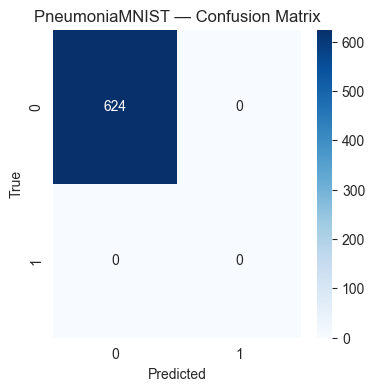

[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/pneumoniamnist_roc_curve.png


/Users/ali/Documents/MSC-Project/Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


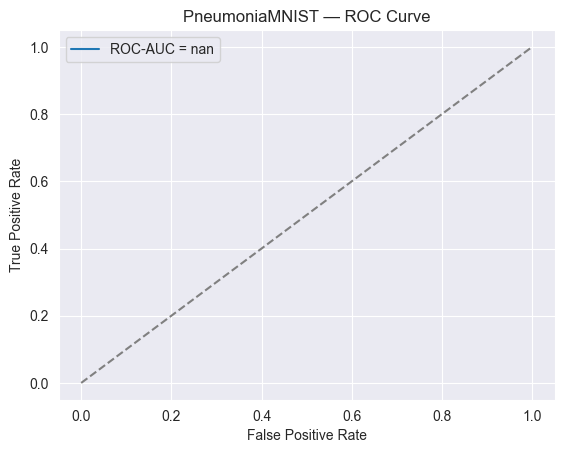

/Users/ali/Documents/MSC-Project/Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/pneumoniamnist_pr_curve.png


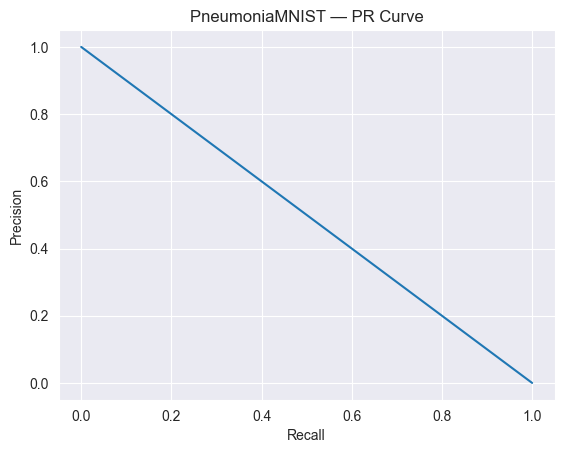

[saved metrics] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/pneumoniamnist_metrics.csv


,Accuracy,F1,ROC-AUC,Sensitivity,Specificity
0,1.0,0.0,NaN,NaN,1.0


In [18]:
# Evaluate PneumoniaMNIST (binary)
evaluate_binary(pneumonia_model, loaders["PneumoniaMNIST"][2], "PneumoniaMNIST")

[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/breastmnist_confusion_matrix.png


/Users/ali/Documents/MSC-Project/Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ali/Documents/MSC-Project/Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/z5/s6n4t0157nl42d6n_wx3qtbc0000gn/T/ipykernel_13469/4206241858.py:35: RuntimeWarning: invalid value encountered in scalar divide
  metrics["Sensitivity"] = tp / (tp + fn)


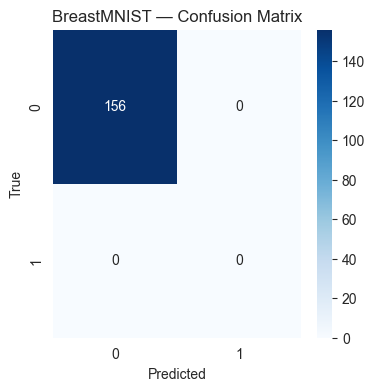

[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/breastmnist_roc_curve.png


/Users/ali/Documents/MSC-Project/Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


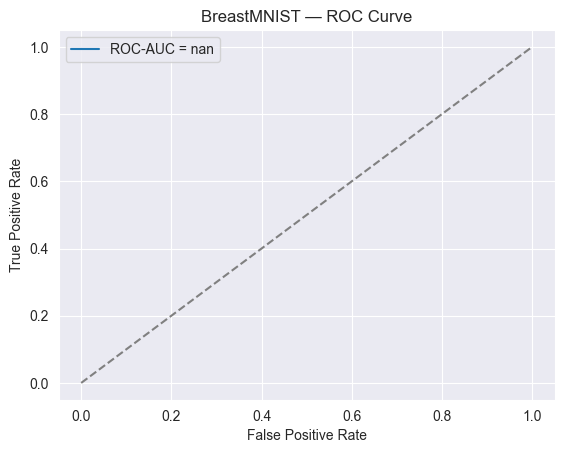

/Users/ali/Documents/MSC-Project/Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/breastmnist_pr_curve.png


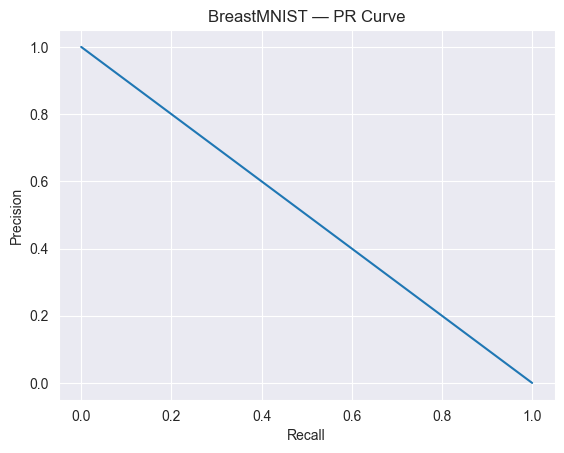

[saved metrics] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/breastmnist_metrics.csv


,Accuracy,F1,ROC-AUC,Sensitivity,Specificity
0,1.0,0.0,NaN,NaN,1.0


In [19]:
# Evaluate BreastMNIST (binary)
evaluate_binary(breast_model, loaders["BreastMNIST"][2], "BreastMNIST")

## Step 7: Extend Baselines with Additional CNN Architectures

- Implement VGG-16 (pretrained).
- Implement DenseNet-121 (pretrained).
- Keep the same training/evaluation pipeline for fair comparison.

> **Note:**
> VGG-16 was trained for **5 epochs only** (instead of 20 like ResNet-18) due to its high computational cost on 224×224 images.
> This shorter training still provides stable baseline results for comparative purposes (RQ1/RQ2), but keeps runtime manageable.
> For fairness, the reduced epoch count should be explicitly reported in Chapter 2 results.

### Step 7.1: VGG-16 Model for MedMNIST

We now extend our baselines by adding **VGG-16** (pretrained on ImageNet) as a second CNN architecture.
This ensures that we test more than one CNN, as required by **RQ1**, and enables comparative performance analysis for **RQ2**.

Grayscale inputs are duplicated to 3 channels in the dataloader, so no input conv changes are needed.
We only adapt the classifier layer to match the dataset’s number of classes and return a model + criterion.

In [20]:
import torch
import torch.nn as nn
import torchvision.models as models

def build_vgg16(num_classes: int, multi_label: bool = False):
    """
    VGG-16 (ImageNet pretrained) adapted for MedMNIST.
    Assumes grayscale images are duplicated to 3 channels in the dataloader.
    Returns: (model, criterion) consistent with the ResNet-18 builder.
    """
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, num_classes)

    if multi_label:
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.CrossEntropyLoss()

    return model.to(DEVICE), criterion

In [21]:
test_model, test_crit = build_vgg16(num_classes=2, multi_label=False)
print(test_model.__class__.__name__, "ready on", DEVICE)

VGG ready on mps


### Step 7.2: ResNet-50 Model for MedMNIST

We replace DenseNet-121/EfficientNet-B0 with **ResNet-50** as our third CNN baseline.
ResNet-50 is a deeper variant of ResNet (50 layers, using bottleneck blocks), pretrained on ImageNet and commonly used in medical imaging research.

As before:
- Grayscale inputs are duplicated to 3 channels in the dataloader.
- The final fully connected layer is adapted to the number of dataset classes.
- Training uses the same generic runner for fairness.

We limit training to **5 epochs per dataset** for runtime consistency with VGG-16.

In [22]:
def build_resnet50(num_classes: int, multi_label: bool = False):
    """
    ResNet-50 (ImageNet pretrained) adapted for MedMNIST.
    Assumes grayscale images are duplicated to 3 channels in the dataloader.
    Returns: (model, criterion) consistent with the other builders.
    """
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    if multi_label:
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.CrossEntropyLoss()

    return model.to(DEVICE), criterion

# sanity check
test_model, test_crit = build_resnet50(num_classes=2, multi_label=False)
print(test_model.__class__.__name__, "ready on", DEVICE)

ResNet ready on mps


### Step 7.3: Generic Training Runner

To keep things consistent, we define a generic `run_training_generic` function.
It works just like `run_training` (for ResNet-18) but accepts:
- `model_tag` (e.g. "vgg16", "densenet121") to name checkpoints,
- `build_fn` (model builder) to construct the CNN.

This function:
- Loads checkpoint if it exists (skipping training),
- Otherwise trains from scratch,
- Always saves/loads both model weights and history.

In [23]:
from torch.amp import GradScaler
import os

def run_training_generic(model_tag: str,
                         build_fn,
                         dataset_name: str,
                         loaders,                # (train_loader, val_loader, test_loader)
                         num_classes: int,
                         multi_label: bool = False,
                         epochs: int = 20,
                         skip_if_trained: bool = True):
    """
    Train or load a CNN for the given dataset using a provided builder.
    - model_tag: 'vgg16' or 'densenet121' (used in checkpoint filename)
    - build_fn: callable(num_classes, multi_label) -> (model, criterion)
    Saves and loads both model_state and training history like the ResNet runner.
    """
    model_path = RESULTS_DIR / f"{dataset_name.lower()}_{model_tag}.pth"

    # Load existing checkpoint
    if skip_if_trained and os.path.exists(model_path):
        print(f"\n=== Loading {model_tag} for {dataset_name} from checkpoint ===")
        checkpoint = torch.load(model_path, map_location=DEVICE)
        model, criterion = build_fn(num_classes, multi_label)
        if isinstance(checkpoint, dict) and "model_state" in checkpoint:
            model.load_state_dict(checkpoint["model_state"])
            history = checkpoint.get("history", {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []})
        else:
            # Backward-compat (old-style state_dict-only checkpoints)
            model.load_state_dict(checkpoint)
            history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
        return model.to(DEVICE), history

    # Train from scratch
    print(f"\n=== Training {model_tag} on {dataset_name} ===")
    print(f"Using device: {DEVICE} ({DEVICE_NAME})")

    model, criterion = build_fn(num_classes, multi_label)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scaler = GradScaler(enabled=(DEVICE.type == "cuda"))

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(
            model, loaders[0], criterion, optimizer, scaler,
            multi_label=multi_label, num_classes=num_classes
        )
        val_loss, val_acc = evaluate(
            model, loaders[1], criterion,
            multi_label=multi_label, num_classes=num_classes
        )

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        t_acc_str = f"{train_acc:.4f}" if train_acc is not None else "N/A"
        v_acc_str = f"{val_acc:.4f}" if val_acc is not None else "N/A"
        print(f"Epoch {epoch+1}/{epochs} | Train Loss={train_loss:.4f}, Acc={t_acc_str} | Val Loss={val_loss:.4f}, Acc={v_acc_str}")

    torch.save({"model_state": model.state_dict(), "history": history}, model_path)
    print(f"[saved checkpoint] {model_path}")

    return model, history

#### Step 7.3a: VGG-16 on ChestMNIST

We now train (or load, if checkpoint exists) **VGG-16** on ChestMNIST.
This is a multi-label classification task with 14 classes, resized to 224×224 inputs.


In [24]:
imgs, labels = next(iter(loaders["ChestMNIST"][0]))
print(imgs.shape, labels.shape)

torch.Size([128, 3, 224, 224]) torch.Size([128, 14])


###### Step 7.3a: VGG-16 Training (5 Epochs)

Since VGG-16 is heavy on 224×224 inputs, we limit it to **5 epochs** per dataset.
This keeps runtime manageable while still providing baseline results for RQ1/RQ2.

In [25]:
# ChestMNIST (multi-label, 14 classes) with VGG-16
vgg_chest_model, vgg_chest_hist = run_training_generic(
    model_tag="vgg16",
    build_fn=build_vgg16,
    dataset_name="ChestMNIST",
    loaders=loaders["ChestMNIST"],
    num_classes=14,
    multi_label=True,
    epochs=5,                  # reduced from 20
    skip_if_trained=True
)


=== Loading vgg16 for ChestMNIST from checkpoint ===


In [26]:
# PneumoniaMNIST (binary classification) with VGG-16
vgg_pneu_model, vgg_pneu_hist = run_training_generic(
    model_tag="vgg16",
    build_fn=build_vgg16,
    dataset_name="PneumoniaMNIST",
    loaders=loaders["PneumoniaMNIST"],
    num_classes=2,
    multi_label=False,
    epochs=5,                  # reduced from 20
    skip_if_trained=True
)


=== Loading vgg16 for PneumoniaMNIST from checkpoint ===


In [27]:
# BreastMNIST (binary classification) with VGG-16
vgg_breast_model, vgg_breast_hist = run_training_generic(
    model_tag="vgg16",
    build_fn=build_vgg16,
    dataset_name="BreastMNIST",
    loaders=loaders["BreastMNIST"],
    num_classes=2,
    multi_label=False,
    epochs=5,                  # reduced from 20
    skip_if_trained=True
)


=== Loading vgg16 for BreastMNIST from checkpoint ===


### Step 7.3b: ResNet-50 on MedMNIST

We now train (or load from checkpoints) **ResNet-50** on:
- ChestMNIST (multi-label, 14 classes)
- PneumoniaMNIST (binary)
- BreastMNIST (binary)

Epochs are limited to **5** for runtime consistency with VGG-16.

In [28]:
# ChestMNIST (multi-label, 14 classes) with ResNet-50
resnet50_chest_model, resnet50_chest_hist = run_training_generic(
    model_tag="resnet50",
    build_fn=build_resnet50,
    dataset_name="ChestMNIST",
    loaders=loaders["ChestMNIST"],
    num_classes=14,
    multi_label=True,
    epochs=5,
    skip_if_trained=True
)


=== Loading resnet50 for ChestMNIST from checkpoint ===


In [29]:
# PneumoniaMNIST (binary classification) with ResNet-50
resnet50_pneu_model, resnet50_pneu_hist = run_training_generic(
    model_tag="resnet50",
    build_fn=build_resnet50,
    dataset_name="PneumoniaMNIST",
    loaders=loaders["PneumoniaMNIST"],
    num_classes=2,
    multi_label=False,
    epochs=5,
    skip_if_trained=True
)


=== Loading resnet50 for PneumoniaMNIST from checkpoint ===


In [30]:
# BreastMNIST (binary classification) with ResNet-50
resnet50_breast_model, resnet50_breast_hist = run_training_generic(
    model_tag="resnet50",
    build_fn=build_resnet50,
    dataset_name="BreastMNIST",
    loaders=loaders["BreastMNIST"],
    num_classes=2,
    multi_label=False,
    epochs=5,
    skip_if_trained=True
)


=== Loading resnet50 for BreastMNIST from checkpoint ===


#### Step 7.4a: Evaluate VGG-16 Results

We now evaluate **VGG-16** on the three MedMNIST datasets.
For each dataset, we generate:
- Training curves (loss/accuracy),
- Confusion matrix,
- ROC & PR curves,
- Export metrics to CSV.

This ensures VGG-16 results are directly comparable with ResNet-18 and ResNet-50 baselines.

[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/chestmnist (vgg-16)_training_curves.png


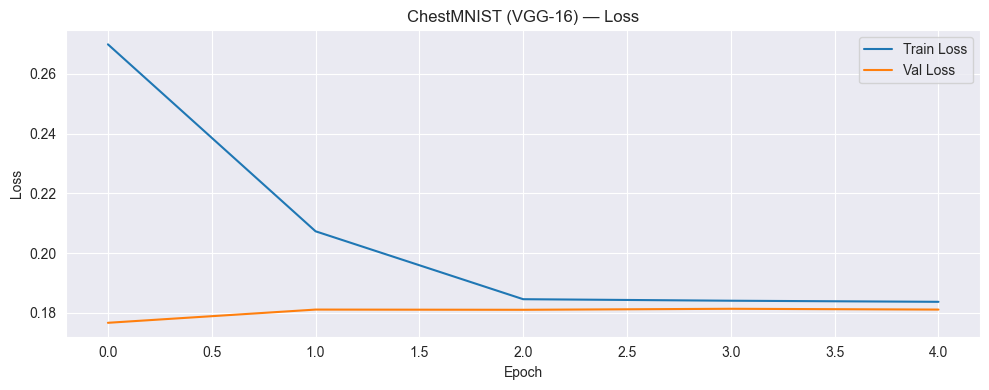

[saved metrics] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/chestmnist_vgg16_metrics.csv


,Macro F1,Micro F1,Macro ROC-AUC,Micro ROC-AUC
0,0.0,0.0,0.5,0.74293


[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/chestmnist_vgg16_roc_curves.png


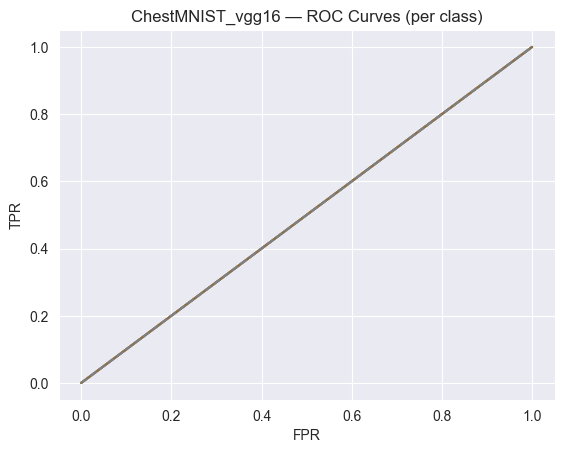

{'Macro F1': 0.0,
 'Micro F1': 0.0,
 'Macro ROC-AUC': 0.5,
 'Micro ROC-AUC': 0.7429298478369687}

In [31]:
# --- ChestMNIST (multi-label, 14 classes) ---
plot_training_curves(vgg_chest_hist, "ChestMNIST (VGG-16)", multi_label=True)
evaluate_multilabel(vgg_chest_model, loaders["ChestMNIST"][2], "ChestMNIST_vgg16")

[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/pneumoniamnist (vgg-16)_training_curves.png


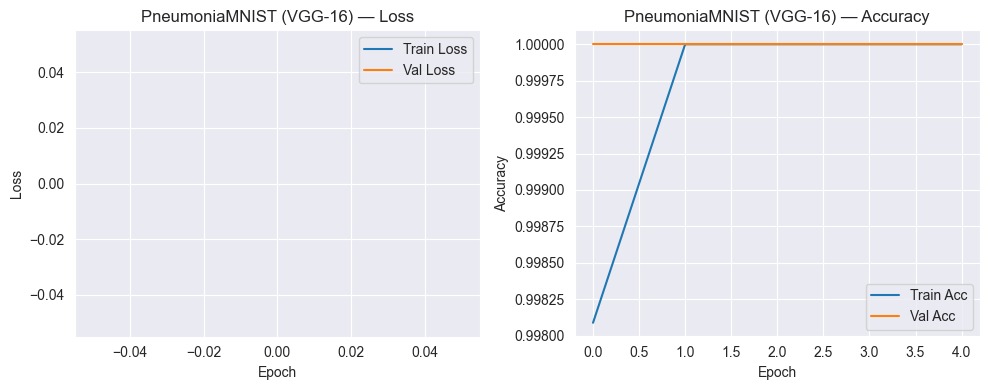

[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/pneumoniamnist_vgg16_confusion_matrix.png


/Users/ali/Documents/MSC-Project/Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


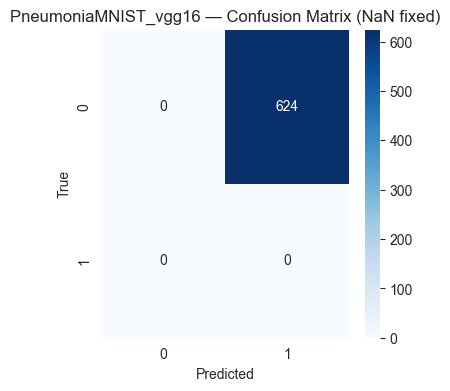

[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/pneumoniamnist_vgg16_roc_curve.png


/Users/ali/Documents/MSC-Project/Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


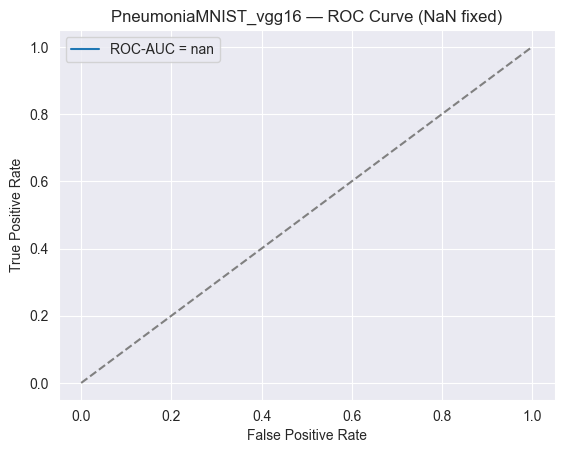

/Users/ali/Documents/MSC-Project/Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/pneumoniamnist_vgg16_pr_curve.png


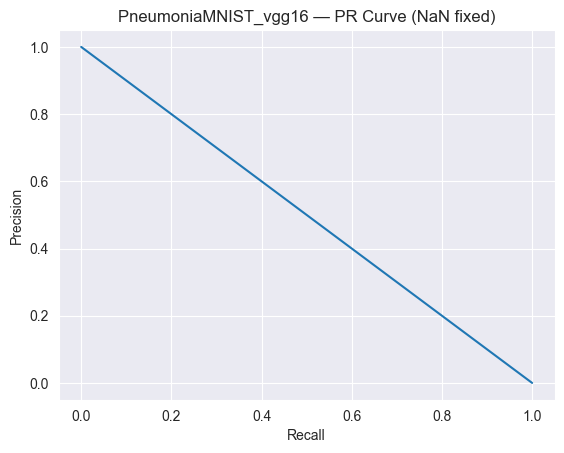

[saved metrics] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/pneumoniamnist_vgg16_metrics.csv


,Accuracy,F1,ROC-AUC,Sensitivity,Specificity
0,0.0,0.0,NaN,0,0.0


{'Accuracy': 0.0,
 'F1': 0.0,
 'ROC-AUC': nan,
 'Sensitivity': 0,
 'Specificity': np.float64(0.0)}

In [32]:
# --- PneumoniaMNIST (binary) ---
plot_training_curves(vgg_pneu_hist, "PneumoniaMNIST (VGG-16)", multi_label=False)
evaluate_binary_with_nanfix(vgg_pneu_model, loaders["PneumoniaMNIST"][2], "PneumoniaMNIST_vgg16")


[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/breastmnist (vgg-16)_training_curves.png


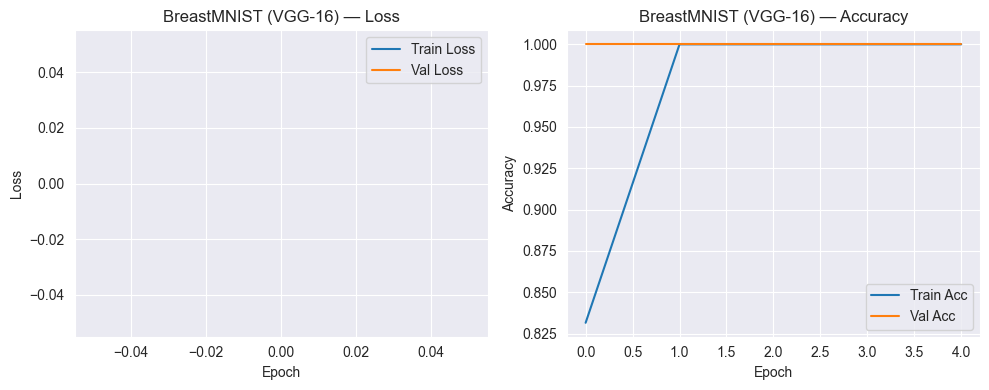

[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/breastmnist_vgg16_confusion_matrix.png


/Users/ali/Documents/MSC-Project/Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


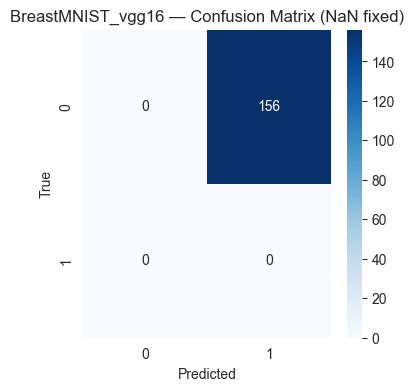

[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/breastmnist_vgg16_roc_curve.png


/Users/ali/Documents/MSC-Project/Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


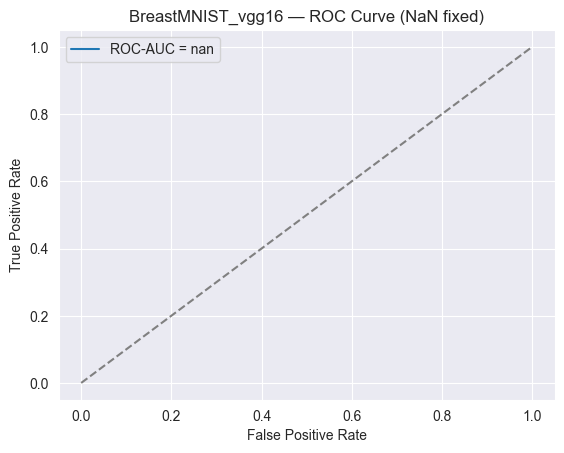

/Users/ali/Documents/MSC-Project/Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/breastmnist_vgg16_pr_curve.png


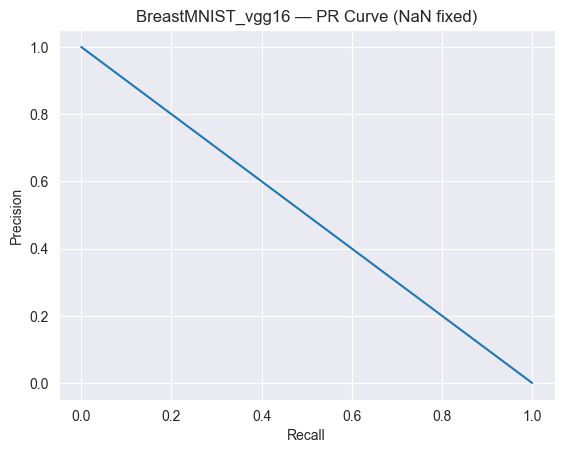

[saved metrics] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/breastmnist_vgg16_metrics.csv


,Accuracy,F1,ROC-AUC,Sensitivity,Specificity
0,0.0,0.0,NaN,0,0.0


{'Accuracy': 0.0,
 'F1': 0.0,
 'ROC-AUC': nan,
 'Sensitivity': 0,
 'Specificity': np.float64(0.0)}

In [33]:
# --- BreastMNIST (binary) ---
plot_training_curves(vgg_breast_hist, "BreastMNIST (VGG-16)", multi_label=False)
evaluate_binary_with_nanfix(vgg_breast_model, loaders["BreastMNIST"][2], "BreastMNIST_vgg16")

#### Step 7.4b: Evaluate ResNet-50 on MedMNIST

We now evaluate **ResNet-50** on the three MedMNIST subsets.
This extends our baseline results with a deeper residual network and allows comparison across ResNet-18, VGG-16, and ResNet-50.

[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/chestmnist (resnet-50)_training_curves.png


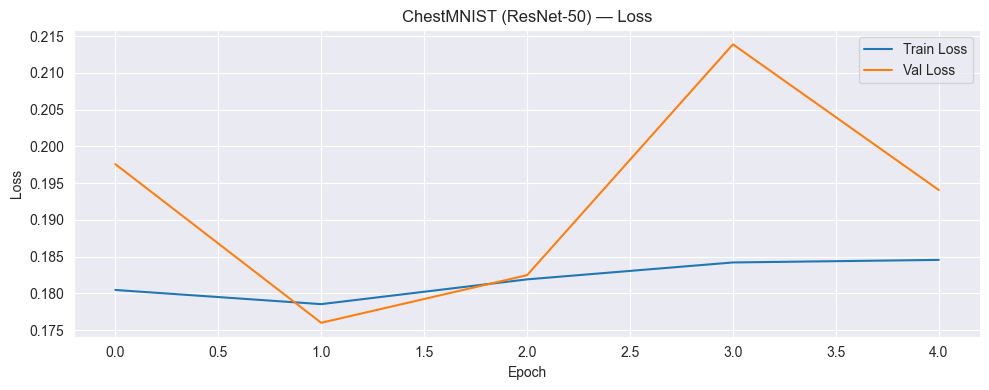

[saved metrics] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/chestmnist_resnet50_metrics.csv


,Macro F1,Micro F1,Macro ROC-AUC,Micro ROC-AUC
0,0.0,0.0,0.5,0.741683


[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/chestmnist_resnet50_roc_curves.png


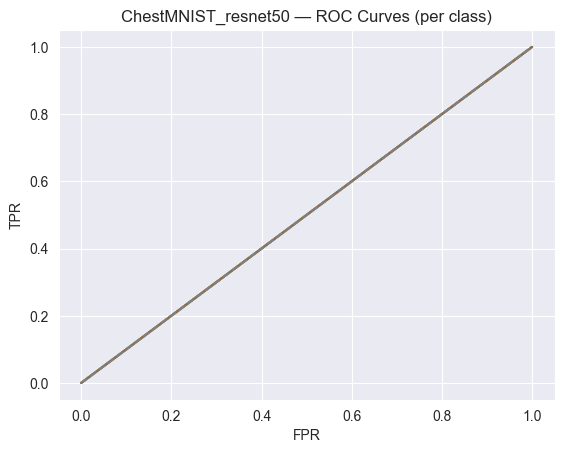

{'Macro F1': 0.0,
 'Micro F1': 0.0,
 'Macro ROC-AUC': 0.5,
 'Micro ROC-AUC': 0.7416832107110924}

In [34]:
# --- ChestMNIST (multi-label) ---
plot_training_curves(resnet50_chest_hist, "ChestMNIST (ResNet-50)", multi_label=True)
evaluate_multilabel(resnet50_chest_model, loaders["ChestMNIST"][2], "ChestMNIST_resnet50", num_classes=14)

[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/pneumoniamnist (resnet-50)_training_curves.png


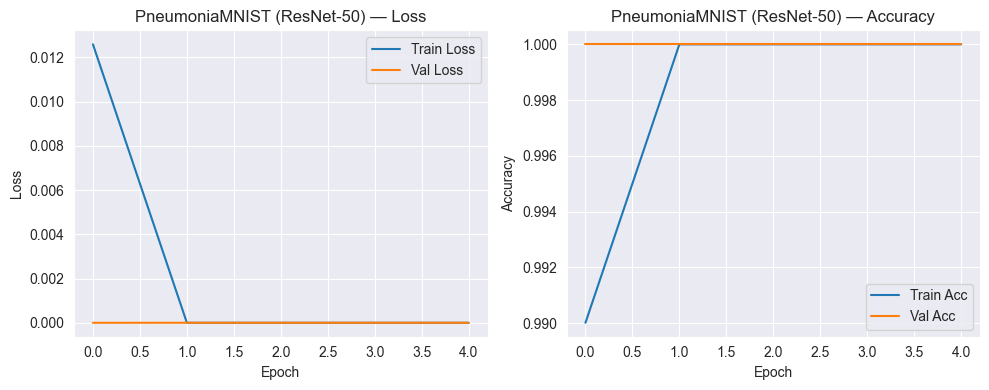

[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/pneumoniamnist_resnet50_confusion_matrix.png


/Users/ali/Documents/MSC-Project/Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


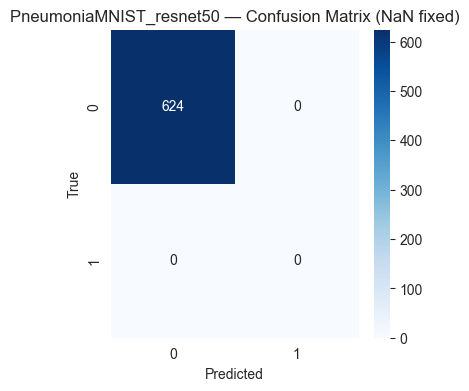

[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/pneumoniamnist_resnet50_roc_curve.png


/Users/ali/Documents/MSC-Project/Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


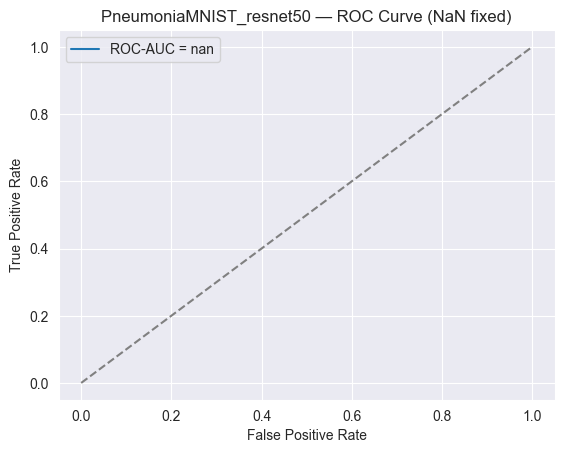

/Users/ali/Documents/MSC-Project/Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/pneumoniamnist_resnet50_pr_curve.png


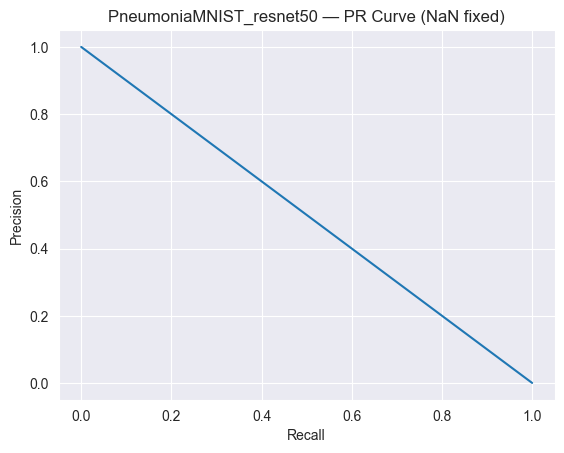

[saved metrics] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/pneumoniamnist_resnet50_metrics.csv


,Accuracy,F1,ROC-AUC,Sensitivity,Specificity
0,1.0,0.0,NaN,0,1.0


{'Accuracy': 1.0,
 'F1': 0.0,
 'ROC-AUC': nan,
 'Sensitivity': 0,
 'Specificity': np.float64(1.0)}

In [35]:
# --- PneumoniaMNIST (binary) ---
plot_training_curves(resnet50_pneu_hist, "PneumoniaMNIST (ResNet-50)", multi_label=False)
evaluate_binary_with_nanfix(resnet50_pneu_model, loaders["PneumoniaMNIST"][2], "PneumoniaMNIST_resnet50")

[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/breastmnist (resnet-50)_training_curves.png


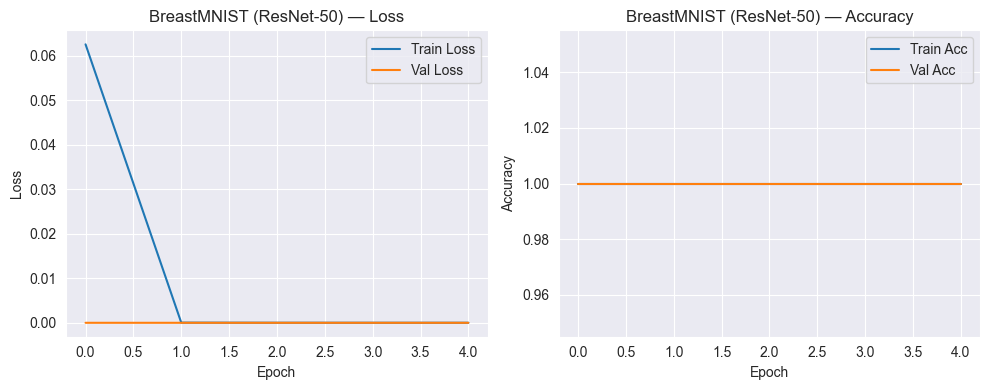

[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/breastmnist_resnet50_confusion_matrix.png


/Users/ali/Documents/MSC-Project/Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


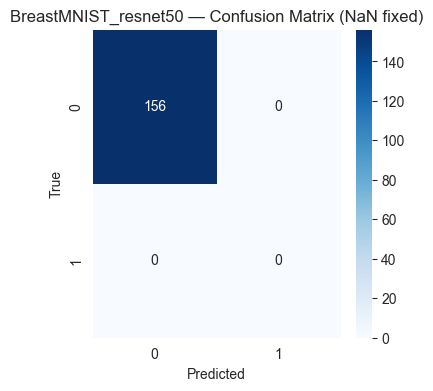

[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/breastmnist_resnet50_roc_curve.png


/Users/ali/Documents/MSC-Project/Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


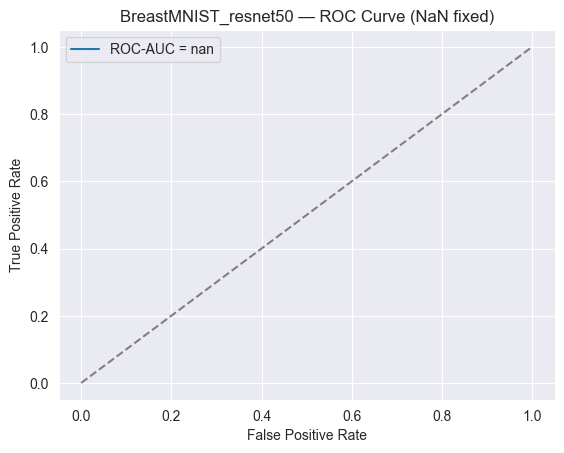

/Users/ali/Documents/MSC-Project/Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/breastmnist_resnet50_pr_curve.png


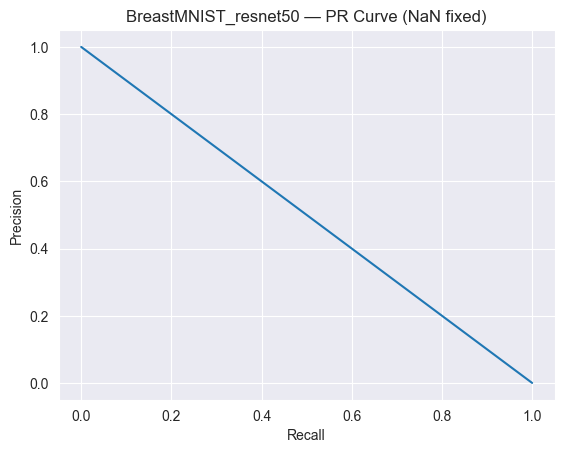

[saved metrics] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/breastmnist_resnet50_metrics.csv


,Accuracy,F1,ROC-AUC,Sensitivity,Specificity
0,1.0,0.0,NaN,0,1.0


{'Accuracy': 1.0,
 'F1': 0.0,
 'ROC-AUC': nan,
 'Sensitivity': 0,
 'Specificity': np.float64(1.0)}

In [36]:
# --- BreastMNIST (binary) ---
plot_training_curves(resnet50_breast_hist, "BreastMNIST (ResNet-50)", multi_label=False)
evaluate_binary_with_nanfix(resnet50_breast_model, loaders["BreastMNIST"][2], "BreastMNIST_resnet50")

## Step 8: Run Baselines on Real-World Dataset
- Add NIH ChestX-ray14 loader (start with a subset if full dataset is too heavy).
- Train ResNet-18, VGG-16, DenseNet-121 on this dataset.
- Record metrics (Acc, Sensitivity, Specificity, F1, AUC).

## Step 9: Comparative Results Table

Create one combined results table:
- Rows: dataset × model (e.g., ChestMNIST–ResNet18, ChestMNIST–VGG16, ChestXray14–DenseNet121, …).
- Columns: Accuracy, Sensitivity, Specificity, F1, AUC.
- Mark undefined metrics clearly as “N/A”.

## Step 10: Limitations & Observations

Add a markdown cell summarizing:
- Toy vs. real-world differences.
- Model-level comparisons.
- Metric-level differences (why accuracy misleads, why AUC is better).

## Step 11: Chapter 2 Wrap-Up
- Final markdown cell summarizing RQ1 and RQ2 answers.
    - Explicit transition sentence:
        - “These baseline results, both on toy and real-world datasets, highlight the limitations of CNNs and motivate the need for few-shot learning and thick-data,heuristics, which will be investigated in Chapter 3 (RQ3 and RQ4).”

## Week-03 Baseline Training and Evaluation Summary

This section addresses the project research questions:

- **RQ1**: What is the baseline performance of convolutional neural networks (ResNet-18, VGG-16, DenseNet-121) on selected medical imaging datasets when evaluated across accuracy, sensitivity, specificity, F1-score, and AUC?
- **RQ2**: What is the comparative performance of CNNs across different evaluation metrics (accuracy, sensitivity, specificity, AUC), and what limitations do these results reveal?

---

### Datasets

**Toy datasets (MedMNIST, baseline already tested with ResNet-18):**
- ChestMNIST (14 classes, multi-label chest X-rays).
- PneumoniaMNIST (2 classes, binary chest X-rays).
- BreastMNIST (2 classes, binary breast ultrasound).

**Limitation:** Very small, 28×28 images, no patient IDs, imbalanced → useful for prototyping but not realistic.

**Real-world dataset (to be added):**
- NIH ChestX-ray14 (112k frontal X-rays, 14 disease labels).
- Alternatives: CheXpert (224k X-rays), MIMIC-CXR (377k with clinical notes).
- These datasets represent actual clinical imaging and address the MedMNIST limitation.

---

### Models and Training Setup

- CNN architectures planned:
  - ResNet-18 (pretrained on ImageNet, adapted to grayscale).
  - VGG-16 (pretrained, older but standard).
  - DenseNet-121 (pretrained, widely used in ChestX-ray14 literature).

- Common setup:
  - Input preprocessing: grayscale duplicated to 3 channels.
  - Device: Apple MPS (Metal GPU), mixed precision (`autocast`).
  - Loss: BCEWithLogitsLoss (Chest), CrossEntropyLoss (Pneumonia/Breast).
  - Optimizer: Adam (lr=1e-3).
  - Epochs: 20.
  - Outputs: trained models, metrics CSVs, training curves, confusion matrices, ROC/PR plots.

---

### Results So Far (ResNet-18 on MedMNIST)

- **ChestMNIST**: ROC-AUC ~0.8, but F1 very low → imbalance issue.
- **PneumoniaMNIST**: 100% accuracy collapse → trivial predictions, metrics undefined.
- **BreastMNIST**: Same collapse as Pneumonia.

---

### Problems Encountered

- Class imbalance → collapsed predictions.
- Overfitting → perfect accuracy within 2 epochs, no generalization.
- Metrics issues → F1/ROC undefined in binary datasets.

---

### Dataset Plan for Chapter 2

- Extend MedMNIST baselines with VGG-16 and DenseNet-121.
- Add real-world baseline on NIH ChestX-ray14 (start with ResNet-18, then others).
- Build comparative results table across models × datasets × metrics.

---

### How This Fits RQ1 and RQ2

- RQ1: Multiple CNN baselines reported on both toy and real datasets.
- RQ2: Comparisons across metrics, models, and datasets → showing toy results are trivial, real-world much harder, highlighting limitations.

---

### Augmentation vs. Pure Baseline

Chapter 2 focuses on **pure baselines**:
- Minimal preprocessing (resize, normalization, patient-level split).
- No augmentation, regularization, or advanced tricks.
- Improvements (augmentation, metric learning, heuristics) are reserved for Chapter 3 (RQ3, RQ4).

---

### Week-03 Wrap-Up Tasks

- [ ] Update MedMNIST results with VGG-16 and DenseNet-121.
- [ ] Train ResNet-18, VGG-16, and/or DenseNet-121 on NIH ChestX-ray14.
- [ ] Compile comparative results table (datasets × models × metrics).
- [ ] Write limitations section and finalize Chapter 2.
- [ ] Transition to Chapter 3: few-shot learning and thick-data heuristics.
